# Porosity analysis

This notebook is a fast-forward version of the notebooks used for teaching porosity analysis in the course 02509. The notebook follows the similar structure as an note for porosity analysis [note](http://people.compute.dtu.dk/vand/notes/porosity_course_note.pdf), which I need to translate from matlab to python.

We start by getting data, which is a scan of a piece of cement with circular porosities.


In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import tifffile
import skimage.filters
import skimage.measure
import scipy


def random_colors(N):
    '''Colormap with randomly permuted jet colors.'''
    colors = plt.cm.jet(np.linspace(0, 1, N))
    colors = np.random.permutation(colors)
    colors = np.vstack((np.array([0.5, 0.5, 0.5, 1]), colors))
    cmap = matplotlib.colors.ListedColormap(colors)
    return cmap

def lognormal_statistics(dist):
    log = np.log(dist)
    stats = {'mean': dist.mean(), 
             'median': np.exp(log.mean()), 
             'mode': np.exp(log.mean() - log.std()**2)
             }
    return stats


In [6]:
# If needed, retrieve volume from QIM data repository. 
# This may take a couple of minutes, but is only done once.
import os
if not os.path.isdir('cement_data'):
    !wget -q https://qim.compute.dtu.dk/data-repository/cement_data.zip

    # Unzip the file to the current directory.
    import shutil
    shutil.unpack_archive('cement_data.zip', 'cement_data')

## Preparation

Both approaches for porosity analysis work on binarized volume. So here we have a simple binarization pipeline. Pipeline consists of Gaussian smoothing, thresholding and morphological filtering. 

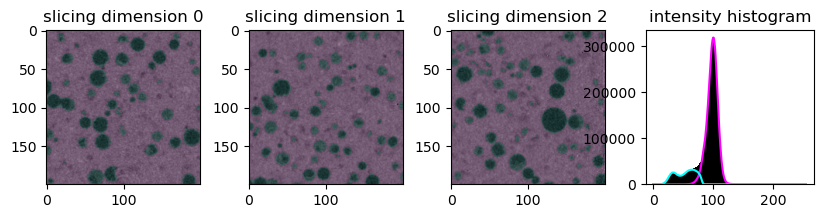

Material density 82%.


In [7]:
# Binarization parameters
smoothing_sigma = 0.5
threshold = 80
morphology_radius = 2

# Load, crop and binarize the volume.
vol = tifffile.imread('cement_data/cement2.tif')
vol = vol[300:500, 200:400, 300:500]
Z, Y, X = vol.shape

# Binarization: gaussian smoothing, thresholding, morphology
bin_vol = skimage.filters.gaussian(vol.astype(float)/255, sigma=smoothing_sigma)
bin_vol = bin_vol > threshold/255
bin_vol = skimage.morphology.binary_closing(bin_vol, skimage.morphology.ball(morphology_radius))

# Look at binarization of three orthogonal cross-sections and histogram.
fig, ax = plt.subplots(1, 4, figsize=(10, 2))
ax[0].imshow(vol[Z//2], cmap=plt.cm.gray, vmin=0, vmax=255)
ax[0].imshow(bin_vol[Z//2], cmap=plt.cm.cool, alpha=0.1, vmin=0, vmax=1)
ax[0].set_title('slicing dimension 0')
ax[1].imshow(vol[:, Y//2, :], cmap=plt.cm.gray, vmin=0, vmax=255)
ax[1].imshow(bin_vol[:, Y//2], cmap=plt.cm.cool, alpha=0.1, vmin=0, vmax=1)
ax[1].set_title('slicing dimension 1')
ax[2].imshow(vol[:, :, X//2], cmap=plt.cm.gray, vmin=0, vmax=255)
ax[2].imshow(bin_vol[:, :, X//2], cmap=plt.cm.cool, alpha=0.1, vmin=0, vmax=1)
ax[2].set_title('slicing dimension 2')
edges = np.arange(257)-0.5
centers= np.arange(256)
hist = np.histogram(vol.ravel(), edges)[0]
ax[3].bar(centers, hist, width=1, color='k', align='edge')
ax[3].plot(centers, np.histogram(vol[bin_vol], edges)[0], color=plt.cm.cool(1.))
ax[3].plot(centers, np.histogram(vol[~bin_vol], edges)[0], color=plt.cm.cool(0.))
ax[3].set_title('intensity histogram')
plt.show()

print(f'Material density {100*bin_vol.sum()/bin_vol.size:.0f}%.')


## Approach 1: Connected compontent analysis (CC)

Connected component analysis may be used directly on binarized volume. If binarization contains regions which should be separated, watershed may help. On the other hand, watershed may over-segment, so dilating distance field can be used as fine-tuning. 

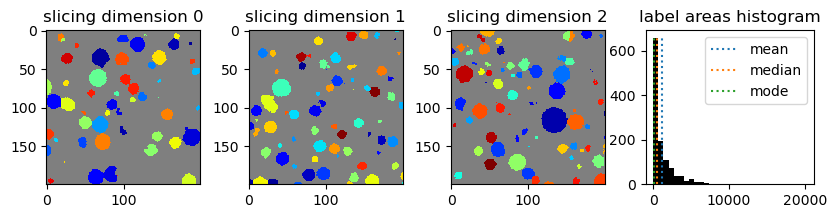

Voxels per porosity 6711.
Label areas mean, median and mode 1203, 508, 68.


In [8]:
dilation_radius = 2

# Watershed transform on modified distance field
distance_field = scipy.ndimage.distance_transform_edt(~bin_vol)
distance_field = skimage.morphology.dilation(distance_field, skimage.morphology.ball(dilation_radius))
labels = skimage.segmentation.watershed(-distance_field, mask=~bin_vol)

props = skimage.measure.regionprops(labels)
nr_cc = labels.max()
label_areas = np.asanyarray([props[i].area for i in range(nr_cc)])

# Histogram and stats
label_areas_hist, label_areas_binedges = np.histogram(label_areas, 30, range=(0, label_areas.max()))
label_areas_stats = lognormal_statistics(label_areas)

# Visualize output of connected component analysis on orhogonal slices.
cmap = random_colors(nr_cc)
fig, ax = plt.subplots(1, 4, figsize=(10, 2))
ax[0].imshow(labels[Z//2], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[0].set_title('slicing dimension 0')
ax[1].imshow(labels[:, Y//2, :], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[1].set_title('slicing dimension 1')
ax[2].imshow(labels[:, :, X//2], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[2].set_title('slicing dimension 2')

ax[3].bar(label_areas_binedges[:-1], label_areas_hist, width=label_areas_binedges[1], align='edge', color='k')
ax[3].set_title('label areas histogram')
for stats in label_areas_stats.keys():
    ax[3].plot([label_areas_stats[stats]]*2, [0, label_areas_hist.max()], ':',label=stats)
ax[3].legend()
plt.show()

print(f'Voxels per porosity {bin_vol.size/nr_cc:.0f}.')
print(f"Label areas mean, median and mode {label_areas_stats['mean']:.0f}, {label_areas_stats['median']:.0f}, {label_areas_stats['mode']:.0f}.")

## Approach 2: Local thickness (LT)

Local thickness is not sensitive to topology. So we apply it directly to binarized volume. No parameters required.

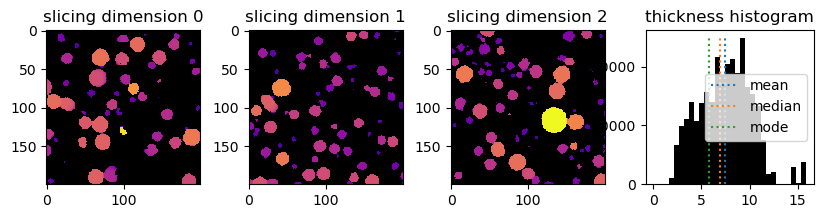

Thickness mean, median and mode 7.5, 6.9, 5.8.


In [11]:
import localthickness as lt


th = lt.local_thickness(~bin_vol)
thmax = th.max()

th_hist, th_binedges = np.histogram(th[~bin_vol], 30, range=(0, thmax))
th_stats = lognormal_statistics(th[~bin_vol])

cmap = lt.black_plasma()

fig, ax = plt.subplots(1, 4, figsize=(10, 2))
ax[0].imshow(th[Z//2], cmap=cmap, vmin=0, vmax=thmax, interpolation='nearest')
ax[0].set_title('slicing dimension 0')
ax[1].imshow(th[:, Y//2, :], cmap=cmap, vmin=0, vmax=thmax, interpolation='nearest')
ax[1].set_title('slicing dimension 1')
ax[2].imshow(th[:, :, X//2], cmap=cmap, vmin=0, vmax=thmax, interpolation='nearest')
ax[2].set_title('slicing dimension 2')

ax[3].bar(th_binedges[:-1], th_hist, width=th_binedges[1], align='edge', color='k')
ax[3].set_title('thickness histogram')
for stats in th_stats.keys():
    ax[3].plot([th_stats[stats]]*2, [0, th_hist.max()], ':', label=stats)
ax[3].legend()

plt.show()

print(f"Thickness mean, median and mode {th_stats['mean']:.02g}, {th_stats['median']:.02g}, {th_stats['mode']:.02g}.")

## Presenting CC results as LC for a more direct comparison

CC result can be presented to resemble LT result. For this, every connected component takes the value of its equivalent radius. 

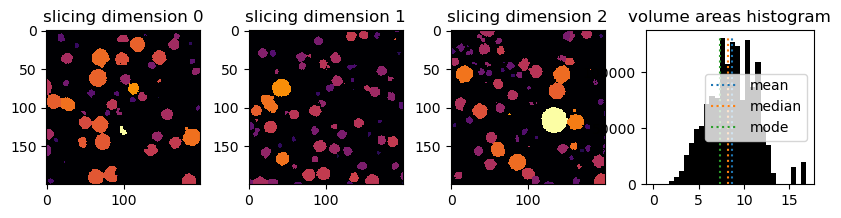

Volume radius mean, median and mode 8.7, 8.3, 7.4.


In [12]:
label_radius = np.asanyarray([props[i].equivalent_diameter_area for i in range(nr_cc)])/2
volume_radius = np.hstack((0, label_radius))   [labels]

rmax = volume_radius.max()

volume_radius_hist, volume_radius_binedges = np.histogram(volume_radius[~bin_vol], 30, range=(0, rmax))
volume_radius_stats = lognormal_statistics(volume_radius[~bin_vol])


cmap = plt.cm.inferno

fig, ax = plt.subplots(1, 4, figsize=(10, 2))
ax[0].imshow(volume_radius[Z//2], cmap=cmap, vmin=0, vmax=rmax, interpolation='nearest')
ax[0].set_title('slicing dimension 0')
ax[1].imshow(volume_radius[:, Y//2, :], cmap=cmap, vmin=0, vmax=rmax, interpolation='nearest')
ax[1].set_title('slicing dimension 1')
ax[2].imshow(volume_radius[:, :, X//2], cmap=cmap, vmin=0, vmax=rmax, interpolation='nearest')
ax[2].set_title('slicing dimension 2')

ax[3].bar(volume_radius_binedges[:-1], volume_radius_hist, width=volume_radius_binedges[1], align='edge', color='k')
ax[3].set_title('volume areas histogram')
for stats in volume_radius_stats.keys():
    ax[3].plot([volume_radius_stats[stats]]*2, [0, volume_radius_hist.max()], ':', label=stats)
ax[3].legend()
plt.show()

print(f"Volume radius mean, median and mode {volume_radius_stats['mean']:.02g}, {volume_radius_stats['median']:.02g}, {volume_radius_stats['mode']:.02g}.")
